<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/project/07nov2021/TimeSeriesSplit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1120]:
#!pip install yfinance
#!pip install pandas-ta==0.2.45b

In [1121]:
#!pip install colorama

In [1122]:
import yfinance as yf
import pandas_ta as ta
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,f1_score
import datetime as dt

from colorama import Fore, Back, Style
import seaborn as sns
import plotly.express as px
import matplotlib
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

In [1123]:
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
           


In [1124]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [1125]:
data_for_modeling=yf.download('^nsei',start='2015-01-01',end='2020-05-01',parse_dates=['Date']).reset_index()

[*********************100%***********************]  1 of 1 completed


In [1126]:
data_for_modeling['Date']=data_for_modeling['Date'].map(dt.datetime.toordinal)

In [1127]:
from numpy.lib.function_base import append
data_for_modeling.ta.macd(fast=45, slow= 30, signal=18, append=True)
data_for_modeling.ta.vortex(length=28,append=True)
data_for_modeling.ta.aroon(length=28,append=True)
data_for_modeling.ta.ema(length=26,append=True)
#data_for_modeling.ta.bbands(append=True)
#data_for_modeling.ta.percent_return(length=28,append=True)
#data_for_modeling.ta.log_return(length=28,append=True)
data_for_modeling.ta.kurtosis(append=True)
data_for_modeling.ta.linreg(length=28,append=True)
data_for_modeling.ta.quantile(append=True)

print()

In [1128]:
data_for_modeling.columns

Index(['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume',
       'MACD_30_45_18', 'MACDh_30_45_18', 'MACDs_30_45_18', 'VTXP_28',
       'VTXM_28', 'AROOND_28', 'AROONU_28', 'AROONOSC_28', 'EMA_26', 'KURT_30',
       'LR_28', 'QTL_30_0.5'],
      dtype='object')

In [1129]:
data_for_modeling['imp']=np.where(data_for_modeling['EMA_26']>data_for_modeling['EMA_26'].shift(1),1,-1)
data_for_modeling['impu']=np.where(data_for_modeling['MACDh_30_45_18']>data_for_modeling['MACDh_30_45_18'].shift(1),1,-1)
data_for_modeling['Impulse']=data_for_modeling['imp']+data_for_modeling['impu']
data_for_modeling['spread']=data_for_modeling['adj_close']-data_for_modeling['LR_28']

In [1130]:
#data_for_modeling.rename(columns={'date':'Date'},inplace=True)

In [1131]:
features=data_for_modeling.columns.tolist()

In [1132]:
features=[feats for feats in features if feats not in ['close','open','low','high','imp','impu']]

In [1133]:
data_for_modeling['Signal']=data_for_modeling['close'].transform(lambda x : np.sign(x.diff(30)))


In [1134]:
data_for_modeling=data_for_modeling.dropna()

In [1135]:
X=data_for_modeling[features]
y=data_for_modeling['Signal']

In [1136]:
chk='Timeseries' #Block

In [1137]:
from sklearn.model_selection import TimeSeriesSplit

if chk=='Block':
  tscv = BlockingTimeSeriesSplit(n_splits=10)

  for fold, (train_index, test_index) in enumerate(tscv.split(X)):
      print("Fold: {}".format(fold))
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]
elif chk=='Timeseries':
  tscv = TimeSeriesSplit(n_splits=10)
  for fold, (train_index, test_index) in enumerate(tscv.split(X)):
      print("Fold: {}".format(fold))
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9


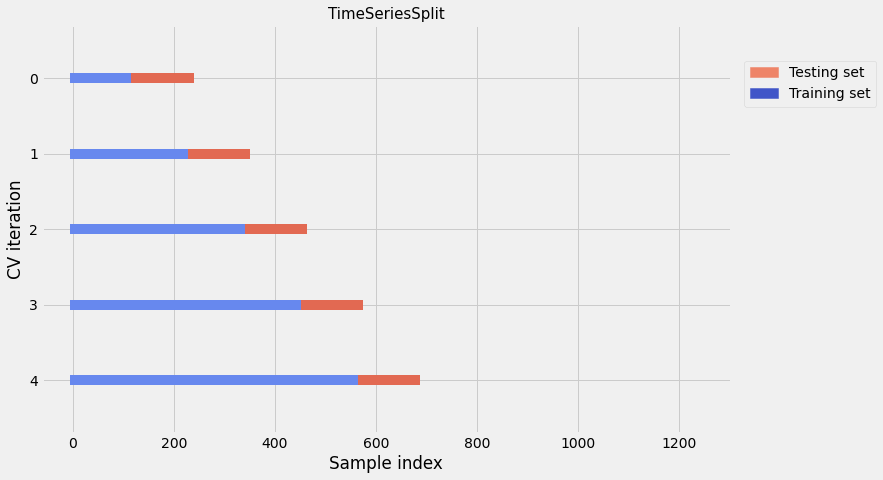

In [1138]:
plot_cv_indices(tscv,5, X, y)

In [1139]:

for train_index, test_index in tscv.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    print("#" * 50)

(122, 17) (122,)
(112, 17) (112,)
##################################################
(234, 17) (234,)
(112, 17) (112,)
##################################################
(346, 17) (346,)
(112, 17) (112,)
##################################################
(458, 17) (458,)
(112, 17) (112,)
##################################################
(570, 17) (570,)
(112, 17) (112,)
##################################################
(682, 17) (682,)
(112, 17) (112,)
##################################################
(794, 17) (794,)
(112, 17) (112,)
##################################################
(906, 17) (906,)
(112, 17) (112,)
##################################################
(1018, 17) (1018,)
(112, 17) (112,)
##################################################
(1130, 17) (1130,)
(112, 17) (112,)
##################################################


In [1140]:
X_train.shape,X_test.shape

((1130, 17), (112, 17))

In [1141]:
rf=RandomForestClassifier()

In [1142]:
rand_frst_clf = RandomForestClassifier(n_estimators = 200,max_depth=20,min_samples_leaf=3,max_features = "auto",min_samples_split=40, criterion = "gini", bootstrap=True,random_state = 42)

In [1143]:

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=3, min_samples_split=40,
                       n_estimators=200, random_state=42)

In [1144]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp*100
feats=X_train.columns
feature_imp

VTXP_28           0.293095
VTXM_28           0.212057
AROONOSC_28       0.129222
AROONU_28         0.120110
MACDh_30_45_18    0.070779
MACD_30_45_18     0.055702
AROOND_28         0.041650
MACDs_30_45_18    0.018833
Impulse           0.013451
date              0.011649
adj_close         0.009170
spread            0.007694
LR_28             0.004712
EMA_26            0.004100
QTL_30_0.5        0.002928
KURT_30           0.002424
volume            0.002424
dtype: float64

In [1145]:
# Make predictions
y_pred = rand_frst_clf.predict(X_test)

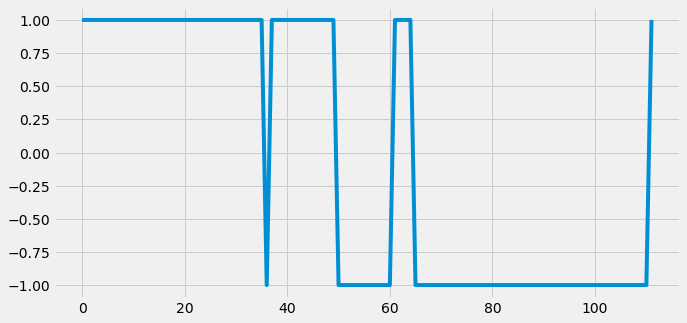

In [1146]:
plt.figure(figsize=(10,5))
pd.Series(y_pred).plot();

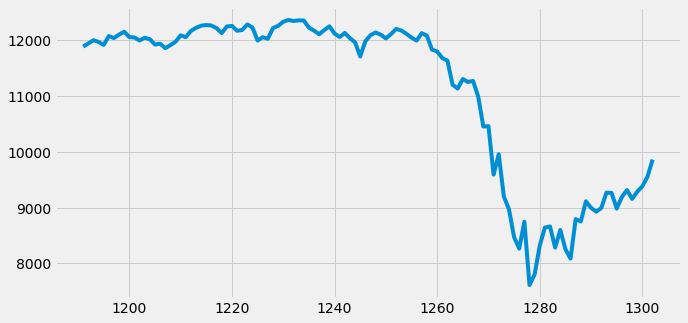

In [1147]:
plt.figure(figsize=(10,5))
X_test['adj_close'].plot();

In [1148]:
timeseries=pd.concat([X_test['adj_close'].reset_index(),pd.Series(y_pred)],axis=1)

In [1149]:
timeseries.columns=['index','close','prediction']

In [1150]:
timeseries.set_index('index',inplace=True)

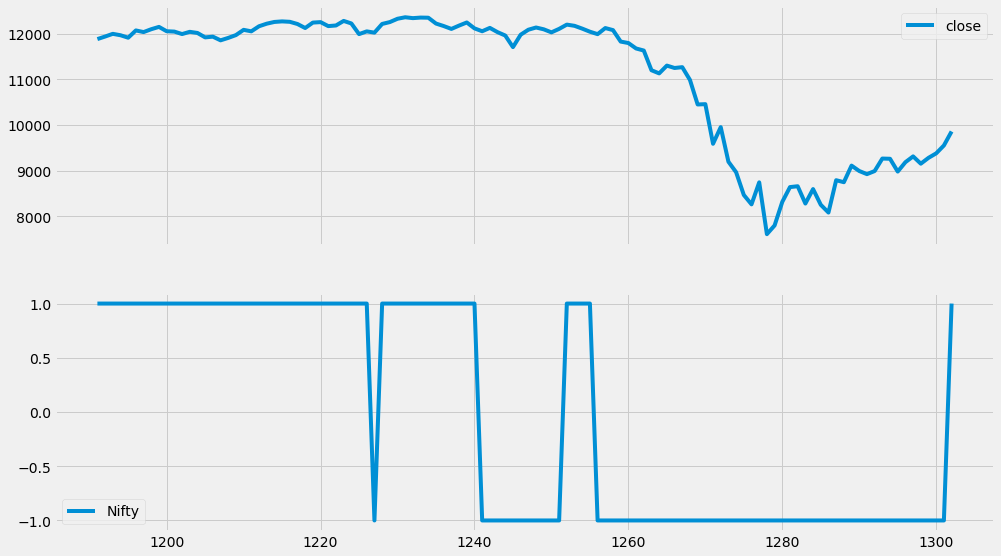

In [1151]:
fig, ax = plt.subplots(2,1, figsize=(15,9),sharex=True)
ax[0].plot(timeseries.loc[:, :].index, timeseries.loc[:, 'close'], label='close')
ax[1].plot(timeseries.loc[:, :].index, timeseries.loc[:, 'prediction'], label='Nifty')
ax[0].legend()
ax[1].legend()
plt.show()

In [1152]:
data_for_testing=yf.download('^nsei',start='2020-06-01',parse_dates=['Date']).reset_index()

[*********************100%***********************]  1 of 1 completed


In [1153]:
data_for_testing['Date']=data_for_testing['Date'].map(dt.datetime.toordinal)

In [1154]:
data_for_testing.ta.macd(fast=45, slow= 30, signal=18, append=True)
data_for_testing.ta.vortex(length=28,append=True)
data_for_testing.ta.aroon(length=28,append=True)
data_for_testing.ta.ema(length=26,append=True)
#data_for_testing.ta.bbands(append=True)
#data_for_testing.ta.percent_return(length=28,append=True)
#data_for_testing.ta.log_return(length=28,append=True)
data_for_testing.ta.kurtosis(append=True)
data_for_testing.ta.linreg(length=28,append=True)
data_for_testing.ta.quantile(append=True)
print()

In [1155]:
data_for_testing['imp']=np.where(data_for_testing['EMA_26']>data_for_testing['EMA_26'].shift(1),1,-1)
data_for_testing['impu']=np.where(data_for_testing['MACDh_30_45_18']>data_for_testing['MACDh_30_45_18'].shift(1),1,-1)
data_for_testing['Impulse']=data_for_testing['imp']+data_for_testing['impu']
data_for_testing['spread']=data_for_testing['adj_close']-data_for_testing['LR_28']

In [1156]:
predict=rand_frst_clf.predict(data_for_testing[features].dropna())

In [1157]:
timeseries=pd.concat([data_for_testing['adj_close'].dropna()[-len(predict):].reset_index(),pd.Series(predict)],axis=1)

In [1158]:
timeseries.columns=['index','adj_close','predict']

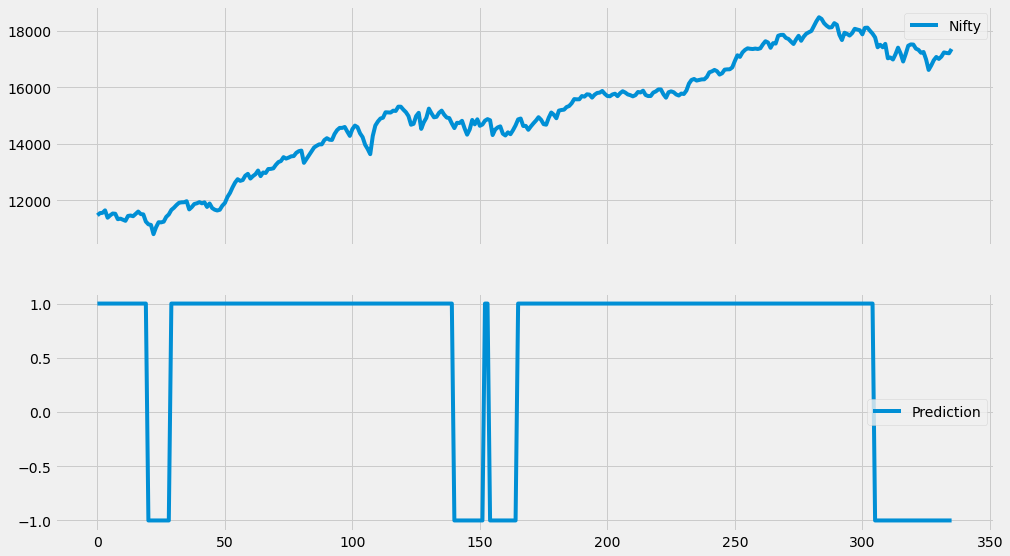

In [1159]:
fig, ax = plt.subplots(2,1, figsize=(15,9),sharex=True)
ax[0].plot(timeseries.loc[:, :].index, timeseries.loc[:, 'adj_close'], label='Nifty')
ax[1].plot(timeseries.loc[:, :].index, timeseries.loc[:, 'predict'], label='Prediction')
ax[0].legend()
ax[1].legend()
plt.show()